In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [115]:
import zipfile
from PIL import Image
import cv2


### Path to zip folder
zip_path = "C:/Users/Sven Jacob/Downloads/DAVIS-data.zip"

FPS_DAVIS = 24

file = 'boat'

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    file_names = zip_file.namelist()
    png_files = [f for f in file_names if f.startswith("DAVIS/JPEGImages/480p/"+file) and f.lower().endswith(".jpg")]
    png_files = np.sort(png_files)
    frames = []
    for png in png_files:
        with zip_file.open(png) as file:
            image_bytes = file.read()
            image_array = np.frombuffer(image_bytes, dtype=np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)
            frames.append(image)

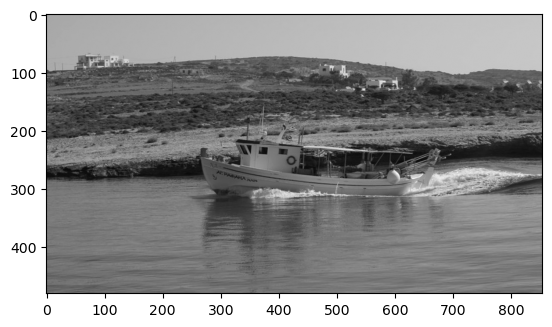

In [116]:
plt.imshow(frames[0],cmap='gray')

In [117]:

def get_frame_size(frame):
    #width height
    return (frame.shape[1],frame.shape[0])

def video_from_images(images, 
                      video_name = 'video.avi',
                      FPS=1,
                      codec = cv2.VideoWriter_fourcc(*'MJPG')):
    print(images[0])
   
    frames_per_second = FPS
    frame_size = get_frame_size(images[0])

    video = cv2.VideoWriter(video_name, 
                            codec, 
                            frames_per_second, 
                            frame_size,isColor=False)  
    
    for image in images:
        
        if len(image.shape) == 2:  
            image = image #cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
        
        if get_frame_size(image) != frame_size:
            print(f"Warning: Resizing frame from {get_frame_size(image)} to {frame_size}")
            image = cv2.resize(image, frame_size)

        video.write(image.astype(np.uint8)) 

    video.release()
    print(f"Video saved as {video_name}")
video_from_images(frames, 'boat.avi',FPS=24)

[[169 169 169 ... 198 198 197]
 [169 169 169 ... 198 198 198]
 [169 169 169 ... 198 198 198]
 ...
 [107 108 107 ... 115 115 115]
 [112 112 111 ... 117 117 117]
 [122 122 119 ... 117 117 117]]
Video saved as boat.avi


In [118]:
M = np.vstack([f.flatten() for f in frames])
M.shape
##rows --> frames ,cols --> pixels

(75, 409920)

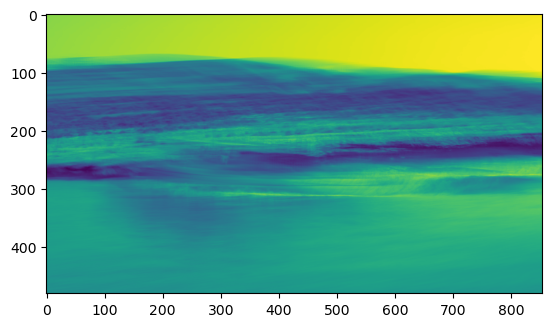

In [119]:
U,s,Vt = np.linalg.svd(M,full_matrices=False)
L=1

S_truncated = np.zeros_like(s)
S_truncated[:L] = s[:L]

M_background = U @ np.diag(S_truncated) @ Vt 
background_frames = M_background.reshape((-1, frames[0].shape[0],frames[0].shape[1]))
plt.imshow(background_frames[30])

In [107]:
from pydmd import DMD
from pydmd.plotter import plot_summary

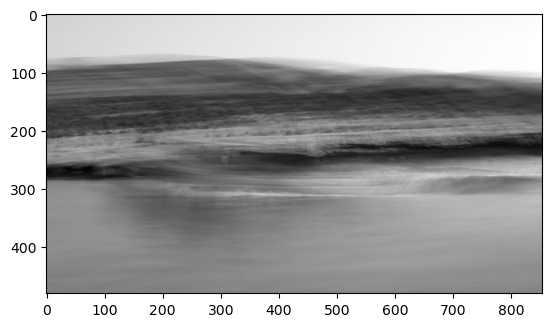

In [134]:
X = M.T.copy()

# window_size = 10
# for i in range(n_frames - window_size + 1):
#     X_window = X[:, i:i + window_size]  # Extract a window of frames
#     dmd = DMD(svd_rank=20)  # Re-initialize DMD
#     dmd.fit(X_window)

dmd = DMD(svd_rank=1)  # Re-initialize DMD

dmd.fit(X)


#plt.imshow(dmd.reconstructed_data[:,0].real.reshape(frames[0].shape[0],frames[0].shape[1]))


def predict(dmd,x,size):
    return dmd.predict(x).reshape(-1,1).reshape(size).real



plt.imshow(predict(dmd,X[:,11],frames[0].shape),cmap='gray')#-X[:,11].reshape(frames[0].shape)),cmap='binary')

#plot_summary(dmd)

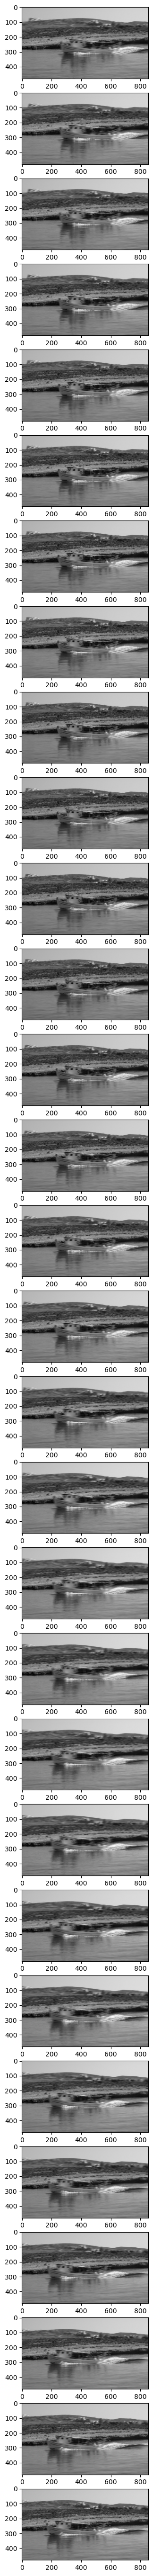

In [122]:
window_size = 5
fig, ax = plt.subplots(30,1,figsize=(5,70))
for i in range(30):
    X_window = X[:, i:i + window_size]  # Extract a window of frames
    dmd = DMD(svd_rank=1)  # Re-initialize DMD
    dmd.fit(X_window)
    ax[i].imshow(dmd.predict(X[:,i+5]).reshape(-1,1).reshape(frames[0].shape[0],frames[0].shape[1]).real,cmap='gray')

In [199]:
#### Koopman observable


def phi_poly(frame, order=2):
    #frame is vector hwX1
    # observable --> [1,x^1,x^2,...,x^k]
    if not isinstance(frame, np.ndarray) or frame.ndim != 1:
        return None 

    p = len(frame)  
    observables = []
    for i in range(p):  
        pixel_observables = [1]  
        for j in range(1, order + 1):
            pixel_observables.append(frame[i]**j)
        observables.extend(pixel_observables) 

    return np.array(observables)


def phi_poly(frame, order=2):
    #frame is vector hwX1
    # observable --> [1,x^1,x^2,...,x^k]
    observable = [np.ones(frame.shape[0])]

    for k in range(1,order+1):
        k_pow = frame**k
        observable.append(k_pow)


    return np.hstack(observable)


 
phi_frame1 = phi_poly( X[:, 0], 2)


def calc_observable(phi,X):
    ### phi observable function
    ### X window of frames [x1,x2,...xn]
    obs = []
    for col in range(X.shape[1]):
        obs.append(phi(X[:,col],order=2))

    return obs


PHIX = np.vstack(calc_observable(phi_poly,X[:,:10])).T
PHIXt = np.vstack(calc_observable(phi_poly,X[:,1:11])).T



In [ ]:
koopman_dmd = DMD(svd_rank=1)
koopman_dmd.fit(PHIX)

In [200]:
def predict(dmd,x,size):
    return dmd.predict(x).reshape(-1,1).reshape(size).real



plt.imshow(predict(koopman_dmd,PHIXt[:,-1],frames[0].shape),cmap='gray')#

ValueError: cannot reshape array of size 1229760 into shape (480,854)